# Mini Project - Predicting UK Data Scientist Salaries

- Part 2: Modeling with ensemble methods and basic NLP

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

In [567]:
import requests
import urllib.request
import bs4
from bs4 import BeautifulSoup
import time
from tqdm import tqdm # a progress bar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Load in the the data of scraped salaries

In [1129]:
data = pd.read_csv('UK_jobs_cln.csv')
data = data.drop(axis=1, columns='Unnamed: 0')

In [1130]:
data.head()

,Job_Title,Company,Location,City,Link,Salary_cln
0,Data and Research Analyst,Cancer Research UK,Stratford,London,/rc/clk?jk=16e8b8e96810af24&fccid=0d06dfb448b2...,31000.0
1,Data Scientist,NHS Midlands and Lancashire Commissioning Supp...,London SE1 6LH,London,/rc/clk?jk=195753e0562ed694&fccid=37c85e352ebb...,27761.0
2,Data Analyst – Content & Media,TalentPool,London EC1R 4RB,London,/rc/clk?jk=8c1cf0cc8aa52ba9&fccid=3e983d79737f...,27000.0
3,Data Analyst,Central London Community Healthcare NHS Trust,London SW1P 2PF,London,/rc/clk?jk=1d3ad812d7a09a77&fccid=7db6814b829e...,32146.0
4,NHS Test and Trace - Data Privacy Analyst,UK Government - Department of Health and Socia...,London,London,/rc/clk?jk=8a28e464e49cdce5&fccid=8b21fd09496a...,33234.5


In [1131]:
data.sort_values(by='Salary_cln', ascending=False).head()


,Job_Title,Company,Location,City,Link,Salary_cln
3179,Lecturer Plumbing,Education Partnership North East (EPNE),Ashington,Brighton,/rc/clk?jk=91d717c582d9b070&fccid=ae83027f1510...,250000.0
1651,Organic Geochemistry Technician,Newcastle University,Newcastle upon Tyne,Newcastle,/rc/clk?jk=2d43d580b8042f5b&fccid=b30d1eae4a0c...,160000.0
3601,Digital Engagement Officer -,Scottish Government,Glasgow G2 8LU,Glasgow,/rc/clk?jk=c40e275f15abdd4e&fccid=7bbf7f016062...,150000.0
161,Programme and Project Officer Q10789,House of Commons UK Parliament,London,London,/rc/clk?jk=76d47e4c2081d42e&fccid=9a060d1841e3...,140000.0
329,Policy Advisor,"UK Government - Department for Digital, Cultur...",London,London,/rc/clk?jk=69d3fc3395f6ac30&fccid=8bf9dca85932...,132600.0


In [1132]:
data.describe(include='all')

,Job_Title,Company,Location,City,Link,Salary_cln
count,4278,4278,4278,4278,4278,4278.000000
unique,3506,1639,1258,10,4153,NaN
top,Staff Nurse,Interface Recruitment,Newcastle upon Tyne,Brighton,/rc/clk?jk=989170926675d384&fccid=8f79579e1143...,NaN
freq,18,61,184,529,2,NaN
mean,NaN,NaN,NaN,NaN,NaN,34890.379383
std,NaN,NaN,NaN,NaN,NaN,14105.751771
min,NaN,NaN,NaN,NaN,NaN,20000.000000
25%,NaN,NaN,NaN,NaN,NaN,25230.500000
50%,NaN,NaN,NaN,NaN,NaN,32070.750000
75%,NaN,NaN,NaN,NaN,NaN,40000.000000


In [1133]:
# Strangely only 10 cities shown
data["City"].value_counts()

Brighton      529
Leeds         515
Newcastle     496
Manchester    460
Bristol       447
Birmingham    430
London        363
Edinburgh     359
Glasgow       357
Nottingham    322
Name: City, dtype: int64

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [1134]:
# mean salary
data["Salary_cln"].mean()

34890.3793828892

In [1135]:
# median salary


median_salary = data["Salary_cln"].median()
median_salary

32070.75

In [1136]:
# consider changing to 75th percentile
high_salary_threshold = data['Salary_cln'].quantile(0.75)
high_salary_threshold

40000.0

### Create a new col of low/high:


In [834]:
from sklearn.preprocessing import Binarizer

In [944]:
# New binary column:

threshold = high_salary_threshold
binarizer = Binarizer(threshold=threshold)
salary_binarized = binarizer.fit_transform(data[['Salary_cln']])

In [945]:
salary_binarized

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [946]:
sal_lst = []
for val in salary_binarized:
    val = float(val)
    sal_lst.append(val)

In [947]:
sal_lst[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [948]:
data['High_Salary'] = pd.Series(sal_lst)
data.tail()

,Job_Title,Company,Location,City,Link,Salary_cln,High_Salary
4273,Registered General Nurse (RGN) - Learning Disa...,Cygnet Health Care,Matlock,Nottingham,/rc/clk?jk=33077bdbeb9661ca&fccid=7d8ec2cb0715...,55000.0,1.0
4274,Manufacturing ERP Specialist,Chase and Holland,Derby,Nottingham,/rc/clk?jk=bb3070f9eb20538c&fccid=7c389b38c7db...,38500.0,0.0
4275,Executive Head Teacher,Bradgate Education Partnership,Syston LE7 1LY,Nottingham,/rc/clk?jk=0ac92991633a38a6&fccid=872dce9d2996...,33150.0,0.0
4276,(Ref: CB) Maintenance Fitter,Essential Recruitment,Burton-On-Trent,Nottingham,/rc/clk?jk=18a470fb8e1f4818&fccid=e2731319a43f...,31000.0,0.0
4277,Category Buyer,Chase and Holland,Nottingham,Nottingham,/rc/clk?jk=8845fe9f641a05a1&fccid=7c389b38c7db...,26953.5,0.0


In [949]:
data['Salary_cln'].describe()

count      4278.000000
mean      34890.379383
std       14105.751771
min       20000.000000
25%       25230.500000
50%       32070.750000
75%       40000.000000
max      250000.000000
Name: Salary_cln, dtype: float64

In [950]:
data['High_Salary'].value_counts()

0.0    3270
1.0    1008
Name: High_Salary, dtype: int64

In [951]:
data.isnull().sum()

Job_Title      0
Company        0
Location       0
City           0
Link           0
Salary_cln     0
High_Salary    0
dtype: int64

#### Get the baseline score

In [952]:
data['High_Salary'].sum()

1008.0

In [953]:
# Percentage of low salaries in this dataset
baseline = data['High_Salary'].value_counts(normalize=True)[0]
baseline

0.7643758765778401

### Looking at the distribution of the salary column

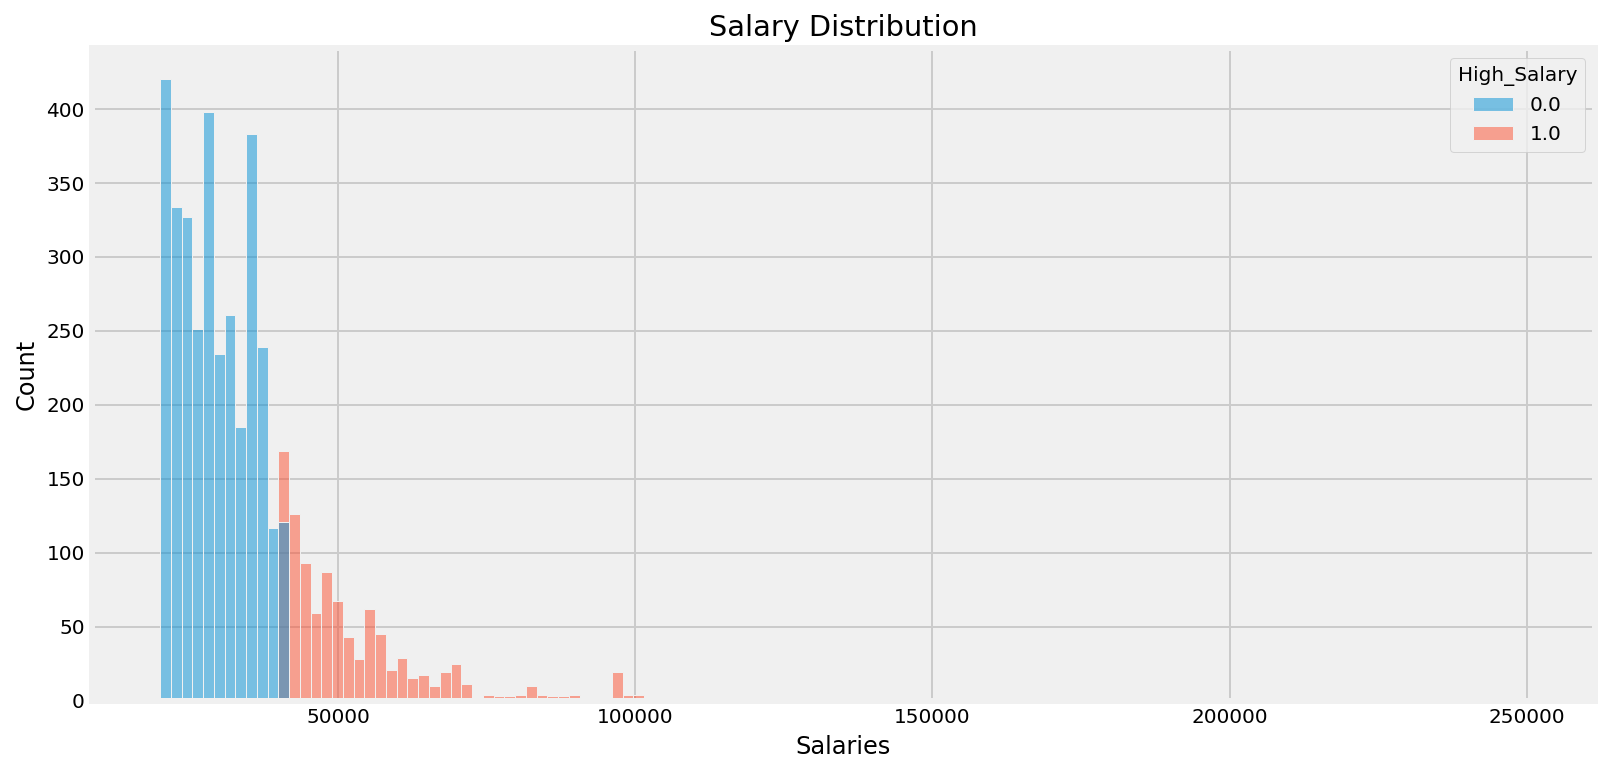

In [1053]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(data, x='Salary_cln', ax=ax, hue='High_Salary')
ax.set_xlabel('Salaries')
ax.set_ylabel('Count')
ax.set_title('Salary Distribution')
plt.show()

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [955]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [956]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from operator import itemgetter
from sklearn import set_config
from sklearn.metrics import accuracy_score, log_loss
set_config(display='diagram')
pd.set_option('display.max_columns', None)

In [957]:
skf = StratifiedKFold(random_state=1)

/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [958]:
def print_scores(model, X_train, y_train, X_test, y_test):
    print("Train Score:  ", model.score(X_train, y_train))
    print("Test Score:   ", model.score(X_test, y_test))
    print("CV scores:    ", cross_val_score(model, X_train, y_train, cv=skf))
    print("CV mean:      ", cross_val_score(model, X_train, y_train, cv=skf).mean())

### Default logit model on city:



### Recheck y values

In [959]:
dfm = data.drop(axis=1, columns='Salary_cln').copy()
y = dfm.pop('High_Salary')
X = dfm.drop(axis=1, columns='Link') # don't think I'll find the link column any useful

In [960]:
y.shape, X.shape

((4278,), (4278, 4))

In [961]:
X.head(2)

,Job_Title,Company,Location,City
0,Data and Research Analyst,Cancer Research UK,Stratford,London
1,Data Scientist,NHS Midlands and Lancashire Commissioning Supp...,London SE1 6LH,London


In [962]:
y.value_counts()

0.0    3270
1.0    1008
Name: High_Salary, dtype: int64

In [963]:
IV = X[['City']]

In [964]:
scaler = StandardScaler(with_mean=False)

In [965]:
# For 'City' col only:

col_trans = ColumnTransformer([('categories', OneHotEncoder(drop='first', sparse=False), ['City'])],
                                remainder='passthrough', sparse_threshold=0)

In [966]:
pipe1 = Pipeline(steps=[('col_trans', col_trans), ('scaler', scaler)])

In [967]:
X_train, X_test, y_train, y_test = train_test_split(IV, y, test_size=0.2, stratify=y, random_state=42)

In [968]:
X_train.value_counts()

City      
Brighton      426
Leeds         424
Newcastle     396
Manchester    370
Bristol       354
Birmingham    333
London        298
Edinburgh     296
Glasgow       282
Nottingham    243
dtype: int64

In [969]:
X_pre = pipe1.fit_transform(X_train)

In [970]:
# This should show 9 cities per value (1st dropped)
# ask on what this represents & why model requires it to be fitted in this format

X_pre

array([[0.        , 3.2836034 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.02903507, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.89342313],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [972]:
# observations per city
X_pre.sum(axis=0)

array([1290.36893846, 1162.39560325, 1053.00728046, 1025.50961201,
       1286.9068698 , 1056.8969014 , 1191.48506408, 1237.92158714,
        946.10182026])

In [973]:
# Use transform on test sets

X_test_pre = pipe1.transform(X_test)

### Base logit model

In [974]:
logit = LogisticRegression()
logit.fit(X_pre, y_train.values)

LogisticRegression()

In [975]:
logit.score(X_pre, y_train.values)

0.7644652250146113

In [976]:
print_scores(logit, X_pre, y_train.values, X_test_pre, y_test.values)

Train Score:   0.7644652250146113
Test Score:    0.764018691588785
CV scores:     [0.7649635  0.76350365 0.76461988 0.76461988 0.76461988]
CV mean:       0.7644653604814957


### Other base models

- default settings don't affect it too much, will need to tinker with.

In [977]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_pre, y_train)

tree = DecisionTreeClassifier()
tree.fit(X_pre, y_train)

forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X_pre, y_train)

ada = AdaBoostClassifier(n_estimators=1000)
ada.fit(X_pre, y_train)

xgb = XGBClassifier(eval_metric='error', use_label_encoder=False)
xgb.fit(X_pre, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

### Note: all of these models are giving the exact same score. Why?

In [979]:
print_scores(knn, X_pre, y_train, X_test_pre, y_test)

Train Score:   0.7644652250146113
Test Score:    0.764018691588785
CV scores:     [0.7649635  0.76350365 0.76461988 0.76461988 0.76461988]
CV mean:       0.7644653604814957


In [981]:
print_scores(tree, X_pre, y_train, X_test_pre, y_test)

Train Score:   0.7644652250146113
Test Score:    0.764018691588785
CV scores:     [0.7649635  0.76350365 0.76461988 0.76461988 0.76461988]
CV mean:       0.7644653604814957


In [983]:
print_scores(forest, X_pre, y_train, X_test_pre, y_test)

Train Score:   0.7644652250146113
Test Score:    0.764018691588785
CV scores:     [0.7649635  0.76350365 0.76461988 0.76461988 0.76461988]
CV mean:       0.7644653604814957


In [985]:
print_scores(ada, X_pre, y_train, X_test_pre, y_test)

Train Score:   0.7644652250146113
Test Score:    0.764018691588785
CV scores:     [0.7649635  0.76350365 0.76461988 0.76461988 0.76461988]
CV mean:       0.7644653604814957


In [987]:
print_scores(xgb, X_pre, y_train, X_test_pre, y_test)

Train Score:   0.7644652250146113
Test Score:    0.764018691588785
CV scores:     [0.7649635  0.76350365 0.76461988 0.76461988 0.76461988]
CV mean:       0.7644653604814957


### Displaying the key coefficients for 'City'

In [988]:
# As far as I know only possible with logit
# How to use with other classifiers?

In [989]:
logit.coef_

array([[-0.12087358, -0.01149104, -0.0766962 , -0.15755809, -0.13736871,
         0.05425732, -0.05698509, -0.22658422, -0.00748961]])

In [990]:
X_pre[0]

array([0.       , 3.2836034, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       ])

In [991]:
city_lst = col_trans.named_transformers_['categories'].get_feature_names()
city_lst

array(['x0_Brighton', 'x0_Bristol', 'x0_Edinburgh', 'x0_Glasgow',
       'x0_Leeds', 'x0_London', 'x0_Manchester', 'x0_Newcastle',
       'x0_Nottingham'], dtype=object)

In [992]:
coefs = pd.DataFrame(list(zip(city_lst, logit.coef_[0])), columns=['feature', 'coef']
            ).sort_values(by='coef')

In [993]:
coefs

,feature,coef
7,x0_Newcastle,-0.226584
3,x0_Glasgow,-0.157558
4,x0_Leeds,-0.137369
0,x0_Brighton,-0.120874
2,x0_Edinburgh,-0.076696
6,x0_Manchester,-0.056985
1,x0_Bristol,-0.011491
8,x0_Nottingham,-0.007490
5,x0_London,0.054257


In [994]:
# The mean salaries of each city & proportion of 'High Salary' in each city (>£40k)

round(data.groupby('City').mean(), 2)



,Salary_cln,High_Salary
City,,
Birmingham,36525.92,0.27
Brighton,34529.92,0.22
Bristol,35576.30,0.27
Edinburgh,35384.52,0.25
Glasgow,34503.59,0.20
Leeds,33492.93,0.21
London,36819.73,0.32
Manchester,33766.33,0.23
Newcastle,33414.52,0.17


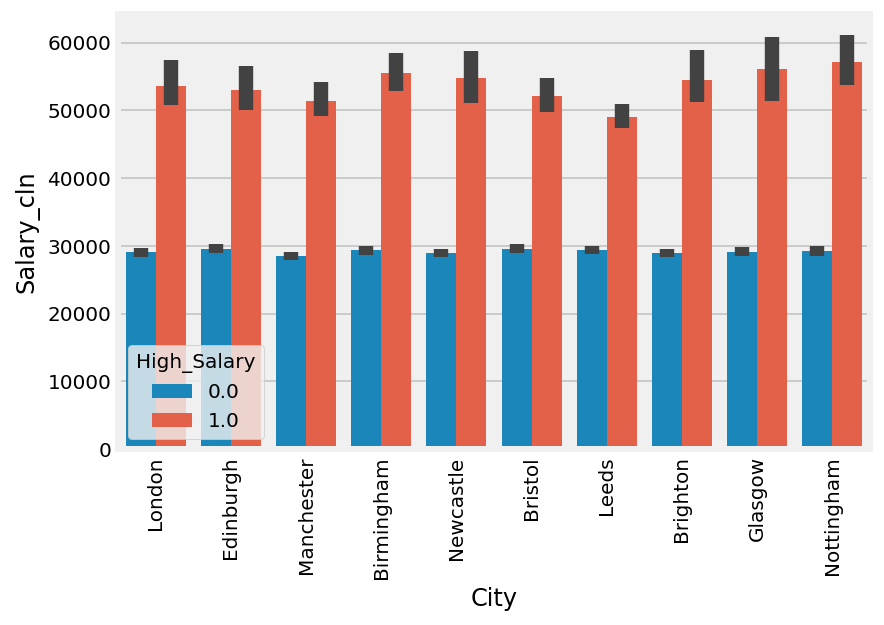

In [1089]:
sns.barplot(data=data, x=data['City'], y=data['Salary_cln'], hue=data['High_Salary'])
plt.xticks(rotation = 90);

## Comment:

- This can partly explain the low scores across all models compared to baseline. 
- It appears that for this dataset your City has a negligible effect on whether you earn a high salary (0.75 threshold, >£40k) or not.
- Strange as it tells me that this dataset is very well balanced regarding salary distribution amongst cities.
- Regarding High salaries, it appears Nottingham, Glasgow and Birmingham have the highest salaries for a given job listing, but predictably, London has the highest proportion of jobs that have high salaries (32%).
- Funny how a simple plot & table can tell me more than the model on which city potentially pays more. 

## Feature engineering

### NLP feature engineering on all categorical columns

### NLP Method 1 - CountVectorizer()

In [1011]:
categoricals = ['Company', 'Location', 'City']

In [1012]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [1013]:
# 'dummies' & 'cvec' are arbitrarily named here

transformer_cvec = ColumnTransformer([('dummies', OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore'),
                                   categoricals), # dummify only Company & Location
                                      ('cvec', CountVectorizer(stop_words='english'),
                                       'Job_Title')], # Only Job_title col (descriptive text)
                                      remainder = 'passthrough', sparse_threshold=1)

In [1014]:
X_train.head(2)

,Job_Title,Company,Location,City
2199,Commissioning Project Officer - Learning Diffi...,South Gloucestershire Council,Yate,Bristol
1498,Cost Analyst,ASC Connections,Tipton,Birmingham


In [1092]:
y_train.value_counts()

0.0    2616
1.0     806
Name: High_Salary, dtype: int64

In [1015]:
scaler2 = StandardScaler(with_mean=False)

In [1016]:
pipe_cvec = make_pipeline(transformer_cvec, scaler2)

In [1017]:
X_tr_cvec = pipe_cvec.fit_transform(X_train)
X_tr_cvec

<3422x4615 sparse matrix of type '<class 'numpy.float64'>'
	with 22048 stored elements in Compressed Sparse Row format>

In [1018]:
X_test_cvec = pipe_cvec.transform(X_test)
X_test_cvec

<856x4615 sparse matrix of type '<class 'numpy.float64'>'
	with 4844 stored elements in Compressed Sparse Row format>

In [1020]:
logit_cvec = LogisticRegression(max_iter=10000)
logit_cvec.fit(X_tr_cvec, y_train.values)

LogisticRegression(max_iter=10000)

In [1021]:
# worse than baseline??
print_scores(logit_cvec, X_tr_cvec, y_train.values, X_test_cvec, y_test.values)

Train Score:   0.9853886616014027
Test Score:    0.6261682242990654
CV scores:     [0.64671533 0.63941606 0.63304094 0.66666667 0.65789474]
CV mean:       0.64874674520852


### Gridsearch for best logit model:

In [1022]:
gs_params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': np.logspace(-4, 4, 9)}


In [1023]:
gs = GridSearchCV(logit_cvec, gs_params, cv=skf, n_jobs=-2, verbose=1)


In [1024]:
gs.fit(X_tr_cvec, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-2)]: Done  77 out of  90 | elapsed:    8.6s remaining:    1.5s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:    9.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
             estimator=LogisticRegression(max_iter=10000), n_jobs=-2,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [1025]:
gs.best_params_


{'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}

In [1026]:
# the best mean cross-validated score, still not much of a change
gs.best_score_


0.7644653604814957

In [1027]:
best_logit_cvec = gs.best_estimator_


In [1028]:
best_logit_cvec.score(X_test_cvec, y_test)


0.764018691588785

In [1029]:
best_logit_cvec.fit(X_tr_cvec, y_train)


LogisticRegression(C=0.0001, max_iter=10000, penalty='l1', solver='liblinear')

In [1030]:
print_scores(best_logit_cvec, X_tr_cvec, y_train, X_test_cvec, y_test)


Train Score:   0.7644652250146113
Test Score:    0.764018691588785
CV scores:     [0.7649635  0.76350365 0.76461988 0.76461988 0.76461988]
CV mean:       0.7644653604814957


### Alternative models:

### Comment

- I though of implementing gridsearches for each but I fear it won't be worthwile as I feel that there's comething off with my dataset or modeling technique, the scores will all be highly similar and not far off from the baseline score.

- For this cvec & tvec model below, hopefully these other classifiers can help identify the best model (looking also at accurcy & log loss), that can help for the model evaluation later.

In [1106]:
# Nice way to run multiple models at once:

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=1000),
    AdaBoostClassifier(n_estimators=500),
    GradientBoostingClassifier(),
    XGBClassifier(eval_metric='error', use_label_encoder=False)]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_tr_cvec, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    
    cv_scores=cross_val_score(clf, X_tr_cvec, y_train, cv=skf)
    print("CV Mean Score: {}".format(cv_scores.mean()))
    
    test_predictions = clf.predict(X_test_cvec)
    acc = accuracy_score(y_test, test_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    test_predictions = clf.predict_proba(X_test_cvec)
    ll = log_loss(y_test, test_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
CV Mean Score: 0.7156396465616597
Accuracy: 73.1308%
Log Loss: 2.577651357215817
DecisionTreeClassifier
****Results****
CV Mean Score: 0.6861531566141632
Accuracy: 66.9393%
Log Loss: 11.418777709999677
RandomForestClassifier
****Results****
CV Mean Score: 0.7478136338412943
Accuracy: 74.4159%
Log Loss: 0.697317858198713
AdaBoostClassifier
****Results****
CV Mean Score: 0.7107000469543688
Accuracy: 70.2103%
Log Loss: 0.6906173588685668
GradientBoostingClassifier
****Results****
CV Mean Score: 0.7562850557049559
Accuracy: 75.4673%
Log Loss: 0.5519492435465978
XGBClassifier
****Results****
CV Mean Score: 0.7454770137021386
Accuracy: 74.7664%
Log Loss: 0.5782708426998389


#### GradientBoost has best scores when also considering accuracy & logloss, will be using this one

### Getting the Coefficients

In [1041]:
# Why is this returning 0s? - something to do with gridsearch params
best_logit_cvec.coef_


array([[0., 0., 0., ..., 0., 0., 0.]])

In [1042]:
# Will just stick to default logit
logit_cvec.coef_

array([[-0.00011921, -0.01767393,  0.08415496, ..., -0.02498618,
        -0.01380375, -0.00044564]])

In [1043]:
transformer_cvec.named_transformers_['dummies'].get_feature_names(categoricals)

array(['Company_0800 Repair', 'Company_15gifts',
       'Company_1625 Independent People', ..., 'City_Manchester',
       'City_Newcastle', 'City_Nottingham'], dtype=object)

In [1044]:
# Find best coefficients

transformer_cvec.named_transformers_['cvec'].get_feature_names()[:5]


['00', '000', '041341', '041422', '044']

In [1036]:
# concat the feature names
# note the order (same as column transformer order)

feature_names_lst =  list(transformer_cvec.named_transformers_['dummies'].get_feature_names(categoricals)) + transformer_cvec.named_transformers_['cvec'].get_feature_names()


In [734]:
# zip the feature names with coefs
# again only logit model can be used

coefs_cvec = pd.DataFrame(list(zip(feature_names_lst, logit_cvec.coef_[0])), columns=['feature', 'coef']
            ).sort_values(by='coef')

In [735]:
# These are more likely coefficients pertaining to the 0 'class' (low salary)

coefs_cvec.head(30)

,feature,coef
2932,children,-0.945213
4312,software,-0.784259
4590,worker,-0.772473
3394,graduate,-0.711098
4235,school,-0.693257
3007,consultant,-0.687565
3129,digital,-0.684895
4421,team,-0.666900
4018,prevention,-0.666045
3577,junior,-0.642361


### Cvec Coefs review

- Where 0.0 = Low Salary & 1.0 = High salary

In [1045]:
# change search term & rerun accordingly
# this can be reused in tvec method below too

def find_text(row):
    """for a row of str"""
    return 'manager' in row.lower()


In [1046]:
data.groupby('High_Salary').mean()


,Salary_cln
High_Salary,
0.0,29136.858104
1.0,53555.076389


In [1047]:
# using a combination of filters to look for specific terms (e.g. 'children' in Job Titles) to check for
# effects on High Salary

filt = data['Job_Title'].apply(find_text)

df_filt = data[filt]

df_filt.groupby('High_Salary').mean()

,Salary_cln
High_Salary,
0.0,29504.677966
1.0,54783.325926


In [1048]:

data[data['Company'] == 'Scottish Government' ]['High_Salary'].value_counts()

0.0    22
1.0     8
Name: High_Salary, dtype: int64

In [1049]:
data[data['City'] == 'Glasgow']['High_Salary'].value_counts()

0.0    286
1.0     71
Name: High_Salary, dtype: int64

## Comment:

- It looks like there's no need to use models here to predict anything important, the scores are too low for me to reliably implement it as opposed to simply looking over plots & charts.
- Any notable features found by the CountVectorizer only have a marginal effect on High Salaries.
- This salaries provided by this dataset may strangely be very similar across cities, job titles. 

### NLP Method 2 - TfidfVectorizer()

In [736]:
categoricals = ['Company', 'Location', 'City']

In [742]:
# 'dummies' & 'cvec' are arbitrarily named here

transformer_tfidf = ColumnTransformer([('dummies', OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore'),
                                   categoricals), # dummify only Company & Location
                                      ('tvec', TfidfVectorizer(stop_words='english'),
                                       'Job_Title')], # Only Job_title col (descriptive text)
                                      remainder = 'passthrough', sparse_threshold=1)

In [743]:
pipe_tfidf = make_pipeline(transformer_tfidf, scaler2)

In [744]:
X_tr_tfidf = pipe_tfidf.fit_transform(X_train)
X_tr_tfidf

<3422x4615 sparse matrix of type '<class 'numpy.float64'>'
	with 22048 stored elements in Compressed Sparse Row format>

In [770]:
logit_tvec = LogisticRegression(max_iter=10000)
logit_tvec.fit(X_tr_tfidf, y_train)

LogisticRegression(max_iter=10000)

In [771]:
X_test_tfidf = pipe_tfidf.transform(X_test)
X_test_tfidf

<856x4615 sparse matrix of type '<class 'numpy.float64'>'
	with 4844 stored elements in Compressed Sparse Row format>

In [775]:
print_scores(logit_tvec, X_tr_tfidf, y_train, X_test_tfidf, y_test)

Train Score:   0.9865575686732905
Test Score:    0.6285046728971962
CV scores:     [0.64963504 0.63941606 0.64766082 0.6754386  0.6622807 ]
CV mean:       0.654886242369915


In [1105]:
# Nice way to run multiple models at once:

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=1000),
    AdaBoostClassifier(n_estimators=500),
    GradientBoostingClassifier(),
    XGBClassifier(eval_metric='error', use_label_encoder=False)]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_tr_tfidf, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    
    cv_scores=cross_val_score(clf, X_tr_tfidf, y_train, cv=skf)
    print("CV Mean Score: {}".format(cv_scores.mean()))
    
    test_predictions = clf.predict(X_test_tfidf)
    acc = accuracy_score(y_test, test_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    test_predictions = clf.predict_proba(X_test_tfidf)
    ll = log_loss(y_test, test_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
CV Mean Score: 0.7109689674307423
Accuracy: 71.8458%
Log Loss: 2.6970719919597004
DecisionTreeClassifier
****Results****
CV Mean Score: 0.6703739275195287
Accuracy: 64.9533%
Log Loss: 12.10471135335655
RandomForestClassifier
****Results****
CV Mean Score: 0.7419656806249201
Accuracy: 73.2477%
Log Loss: 0.7181683350233176
AdaBoostClassifier
****Results****
CV Mean Score: 0.6928731805182055
Accuracy: 70.0935%
Log Loss: 0.6898264754860042
GradientBoostingClassifier
****Results****
CV Mean Score: 0.7556998335254194
Accuracy: 75.8178%
Log Loss: 0.5577631714793986
XGBClassifier
****Results****
CV Mean Score: 0.7425479147991634
Accuracy: 73.9486%
Log Loss: 0.6037373424259616


#### Looks like we'll use the GradientBoostingClassifier for here too

### Get coefs from logit model (mean CV score of 0.6549)
- Sadly only logit model can be used.
- Not too bad as scores are very similar anyway & for some reason not better than baseline

In [776]:
logit_tvec.coef_

array([[-5.98375192e-05, -1.91265248e-02,  8.33963404e-02, ...,
        -3.73353236e-02, -1.20355522e-02, -1.35057381e-02]])

In [777]:
# concat the feature names
# note the order (same as column transformer order)

feature_names_tfidf =  list(transformer_tfidf.named_transformers_['dummies'].get_feature_names(categoricals)) + transformer_tfidf.named_transformers_['tvec'].get_feature_names()

In [778]:
# zip the feature names with coefs

coefs_tvec = pd.DataFrame(list(zip(feature_names_tfidf, logit_tvec.coef_[0])), columns=['feature', 'coef']
            ).sort_values(by='coef')
coefs_tvec.head(30)

,feature,coef
2932,children,-0.751973
4312,software,-0.744452
3129,digital,-0.711580
4398,support,-0.691733
4235,school,-0.672198
3011,content,-0.641215
1937,Location_Hartlepool TS24 9AG,-0.610066
3577,junior,-0.606990
4018,prevention,-0.606676
2185,Location_Newcastle upon Tyne,-0.604267


### TF-idf coefs review

In [1055]:
# change search term & rerun accordingly to check effects on high salary

def find_text(row):
    """for a row of str"""
    return 'children' in row.lower()

In [1056]:
data.groupby('High_Salary').mean()


,Salary_cln
High_Salary,
0.0,29136.858104
1.0,53555.076389


In [1072]:
# With filter
# some marginal increase, but not that significant

filt = data['Job_Title'].apply(find_text)

df_filt = data[test]

df_filt.groupby('High_Salary').mean()


,Salary_cln
High_Salary,
0.0,28517.390909
1.0,59728.160000


### Comment:

- Very similar to the cvec method, with similar rankings for the most relevant coefficients
- As it looks there seems not much point to look for specific words in the vectorizer.
- However this is limited as only a base logit model seems to work in order for me to fish out the coefficients.
- There has to be a way for me to retrieve coefficients for other models.

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

- Make a confusion matrix where false positives = predicted low when actual = high

### Only comparing the 'best' cvec model & the 'best' tvec model

In [793]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
import scikitplot as skplt
from matplotlib.colors import ListedColormap

### Confusion Matrices

### CVEC Confusion Matrix

In [1108]:
gboost_cvec = GradientBoostingClassifier()
gboost_cvec.fit(X_tr_cvec, y_train.values)
print("CV Mean:", np.mean(cross_val_score(gboost_cvec, X_tr_cvec, y_train.values, cv=skf)))

CV Mean: 0.7574529389166347


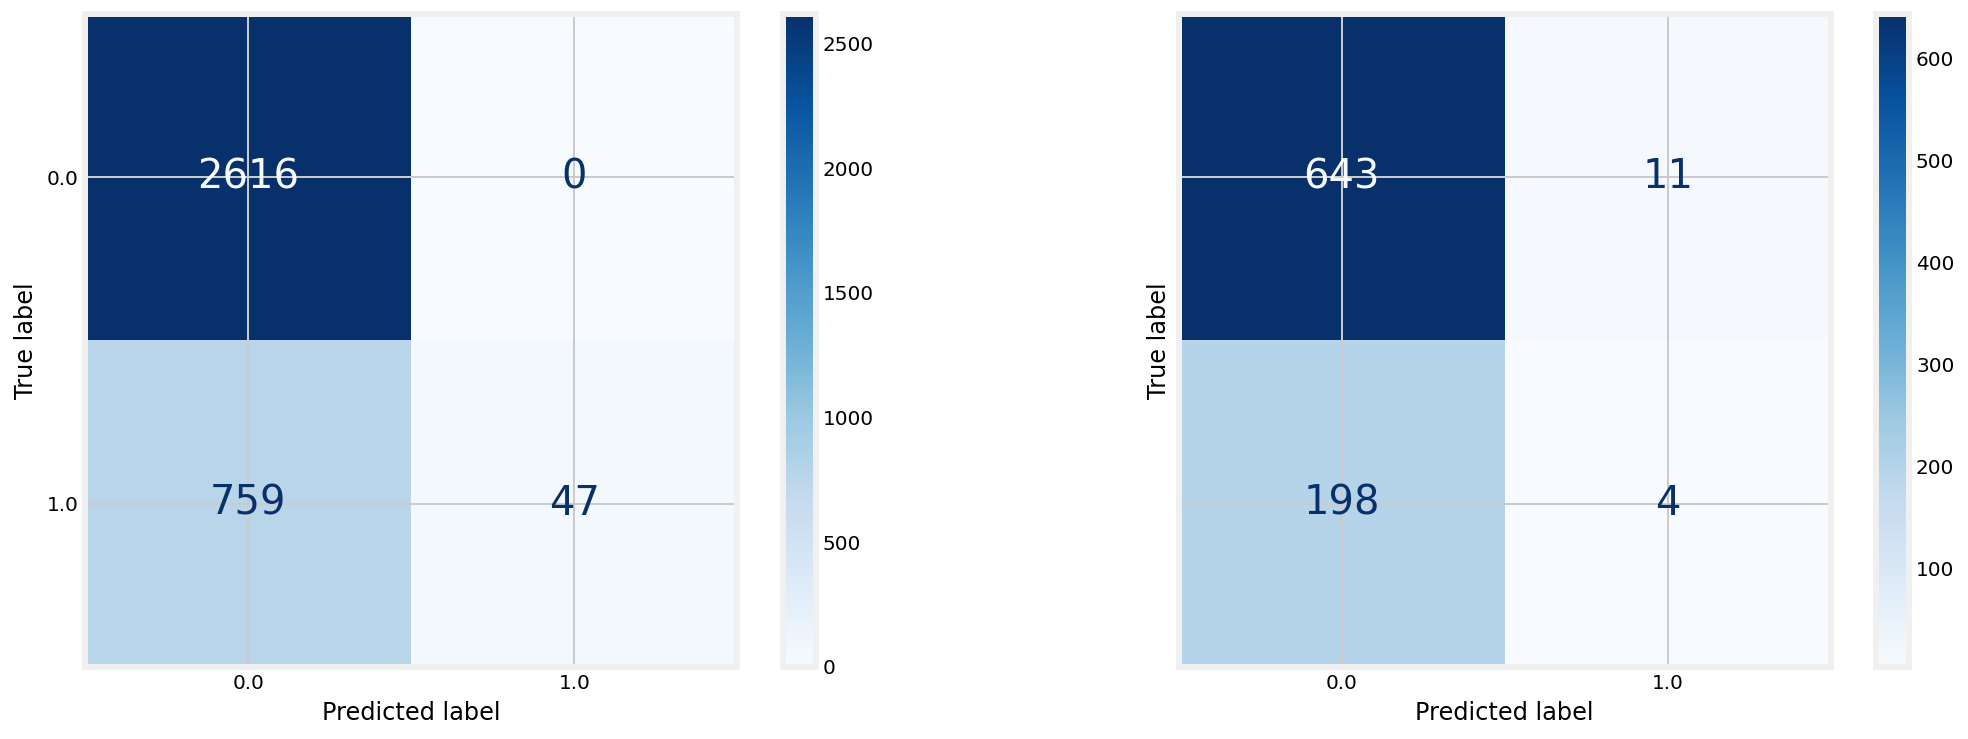

In [1109]:
# Confusion Matrix, cvec (train left, test right):

# Read false positives through columns (vertically)
# Read false negatives through rows (horizontally)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)


plot_confusion_matrix(gboost_cvec, X_tr_cvec, y_train, cmap='Blues', ax=ax[0])
plot_confusion_matrix(gboost_cvec, X_test_cvec, y_test, cmap='Blues', ax=ax[1])

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()


### TVEC Confusion Matrix

In [1110]:
gboost_tvec = GradientBoostingClassifier()
gboost_tvec.fit(X_tr_tfidf, y_train.values)
print("CV Mean:", np.mean(cross_val_score(gboost_tvec, X_tr_tfidf, y_train.values, cv=skf)))

CV Mean: 0.7542374183634267


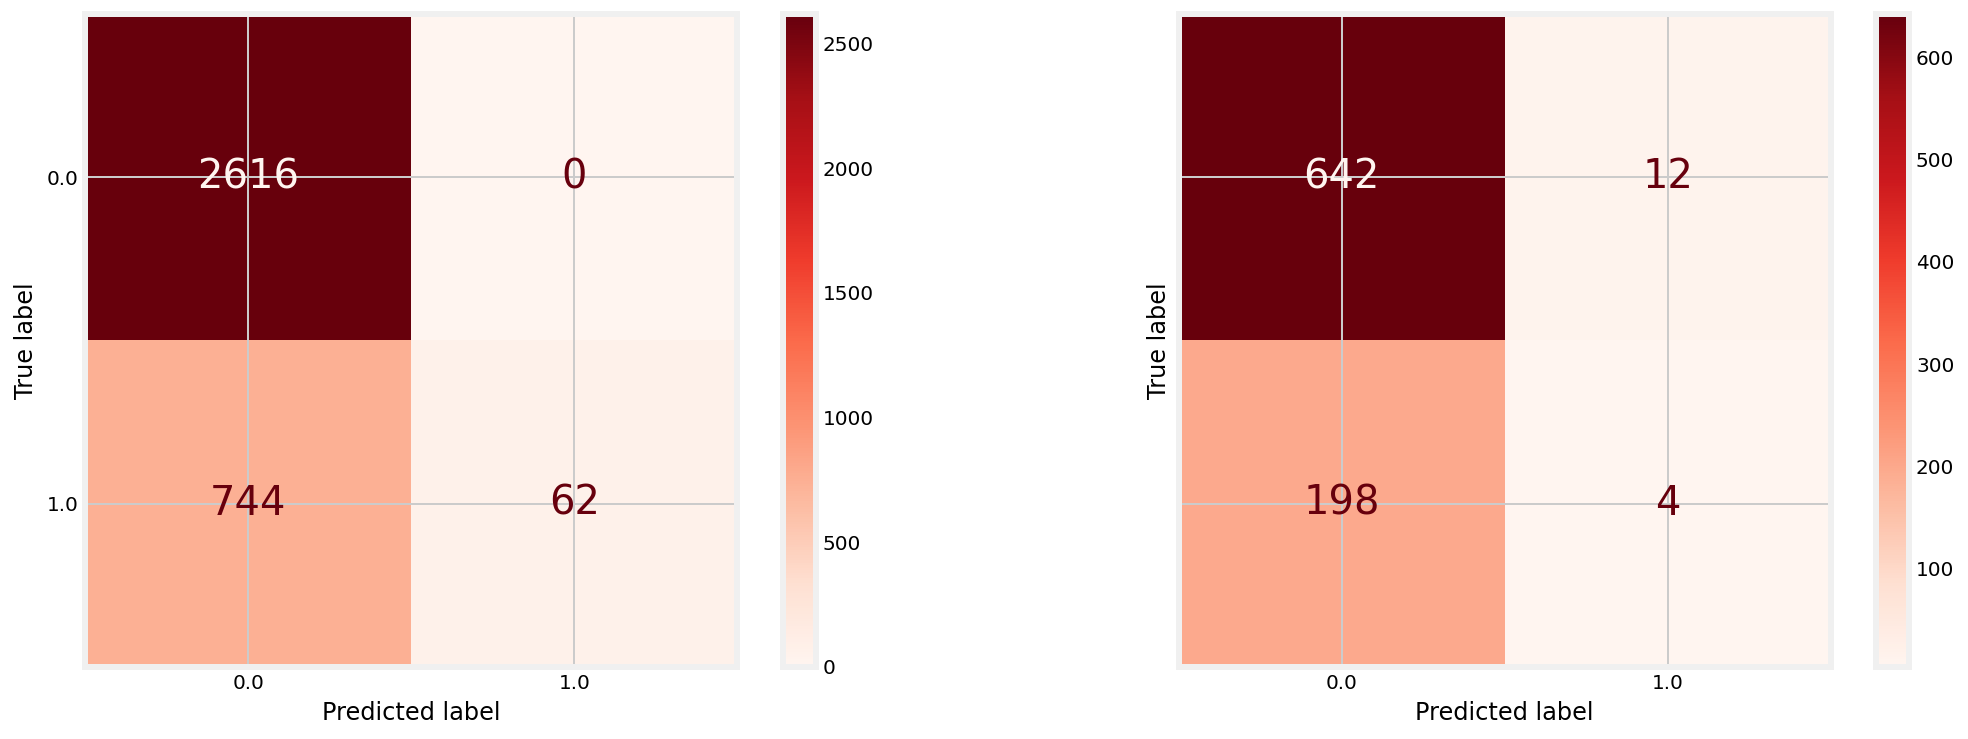

In [1111]:
# Confusion Matrix, tvec (train left, test right):

# Read false positives through columns (vertically)
# Read false negatives through rows (horizontally)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)


plot_confusion_matrix(gboost_tvec, X_tr_tfidf, y_train, cmap='Reds', ax=ax[0])
plot_confusion_matrix(gboost_tvec, X_test_tfidf, y_test, cmap='Reds', ax=ax[1])

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()


In [1112]:
# Test Predictions for cvec & tvec:

pred_cvec = gboost_cvec.predict(X_test_cvec)
pred_cvec[:10]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1116]:
pred_tvec = gboost_tvec.predict(X_test_tfidf)
pred_tvec[:10]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Classification Reports

In [1117]:
print(classification_report(y_test, pred_cvec))


              precision    recall  f1-score   support

         0.0       0.76      0.98      0.86       654
         1.0       0.27      0.02      0.04       202

    accuracy                           0.76       856
   macro avg       0.52      0.50      0.45       856
weighted avg       0.65      0.76      0.67       856



In [1118]:
print(classification_report(y_test, pred_tvec))


              precision    recall  f1-score   support

         0.0       0.76      0.98      0.86       654
         1.0       0.25      0.02      0.04       202

    accuracy                           0.75       856
   macro avg       0.51      0.50      0.45       856
weighted avg       0.64      0.75      0.67       856



In [1073]:
# PR Curve with f1-score level lines:

def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

### ROC & Precision Recall Curves:

### CVEC

In [1119]:
cvec_prob_train = gboost_cvec.predict_proba(X_tr_cvec)
cvec_prob_test = gboost_cvec.predict_proba(X_test_cvec)

### ROC-AUC Curves

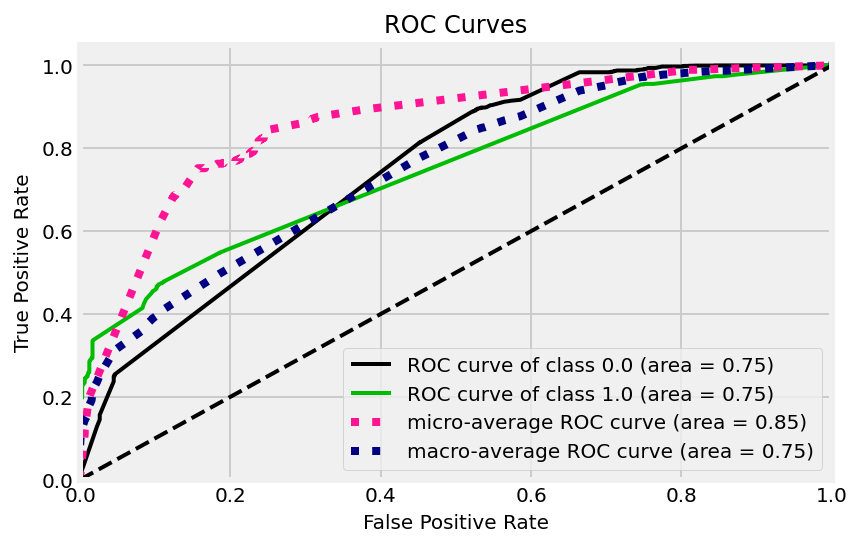

In [1120]:
# ROC Curve (train)

skplt.metrics.plot_roc(y_train, cvec_prob_train)
plt.show()

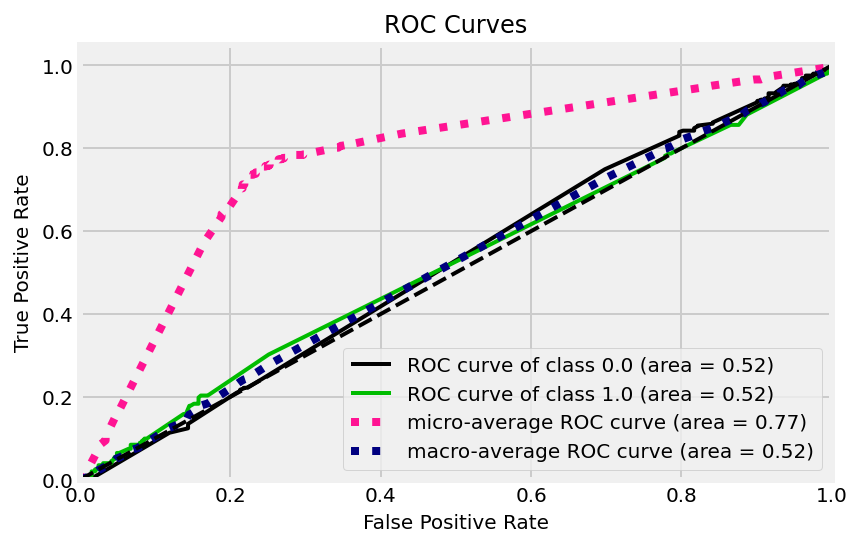

In [1121]:
# ROC Curve (test)

skplt.metrics.plot_roc(y_test, cvec_prob_test)
plt.show()

### Precision Recall

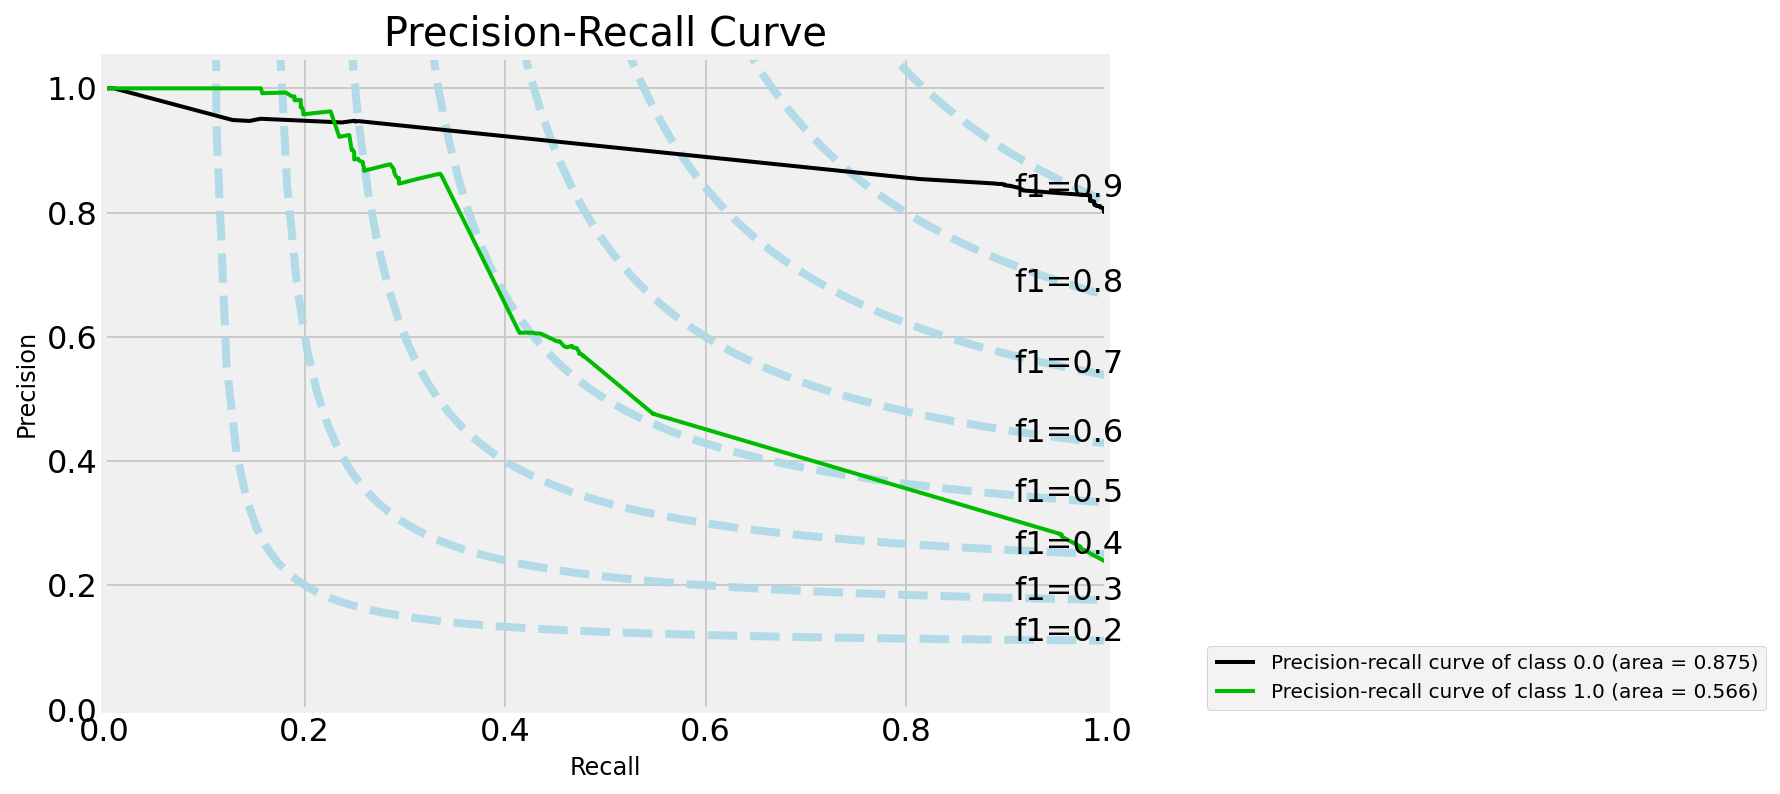

In [1122]:
# train


fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_train, cvec_prob_train,
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

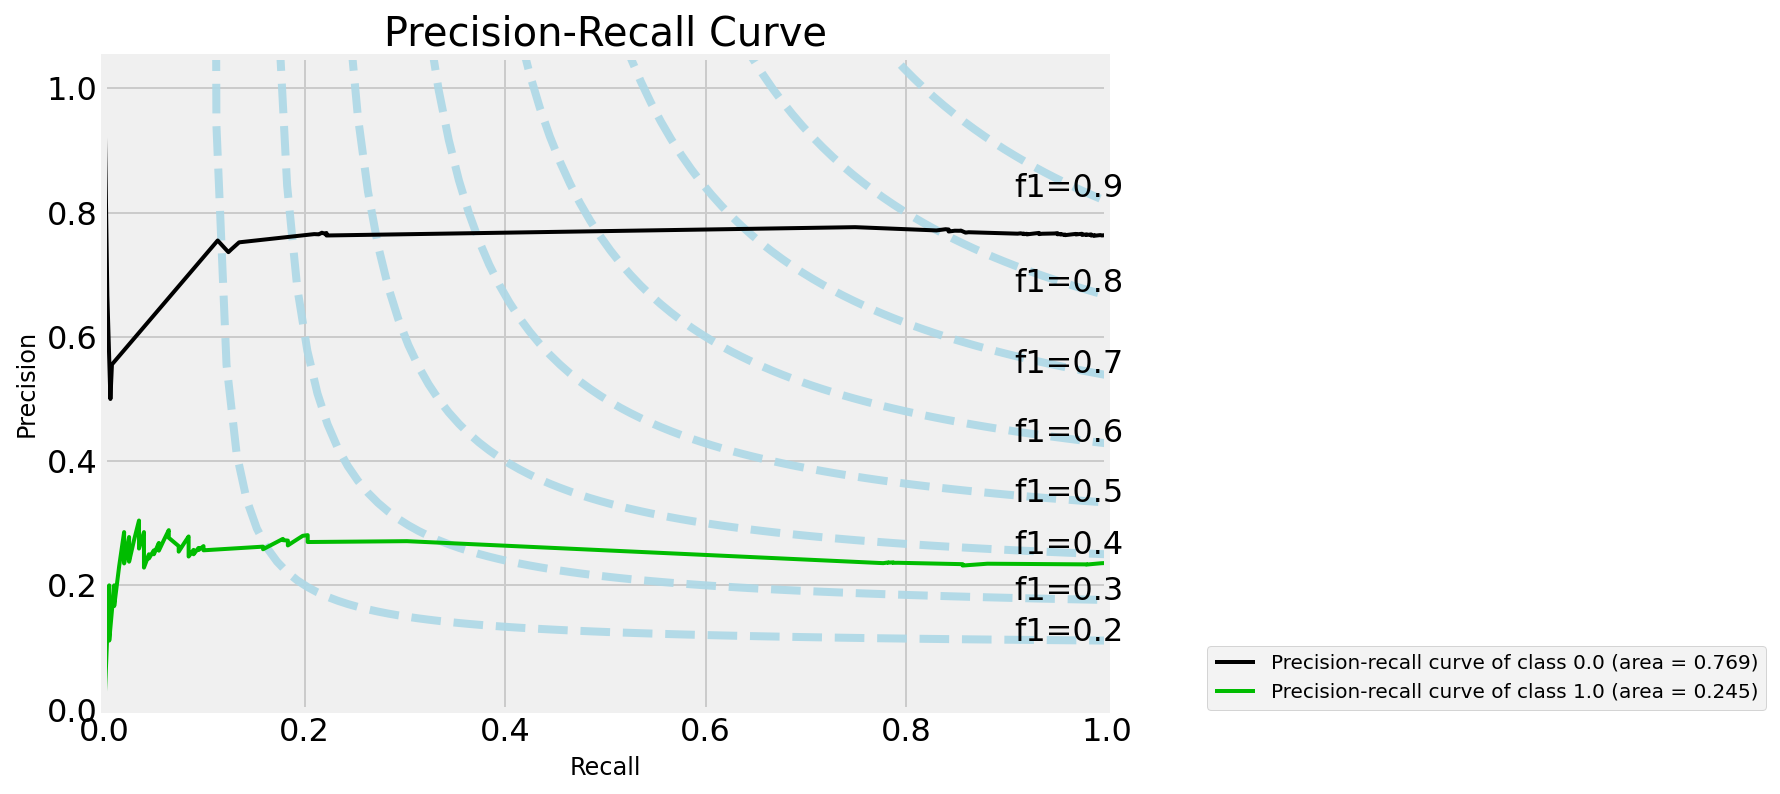

In [1123]:
# test

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, cvec_prob_test,
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

### TVEC

In [1124]:
tvec_prob_train = gboost_tvec.predict_proba(X_tr_tfidf)
tvec_prob_test = gboost_tvec.predict_proba(X_test_tfidf)

### ROC-AUC Curves

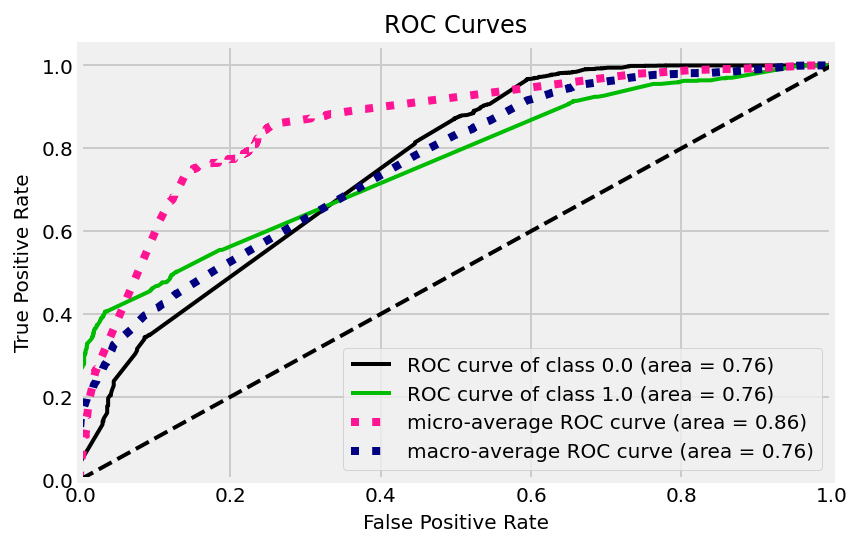

In [1125]:
# ROC Curve (train)

# Note, class imbalnce can cause ROC curves to be poor visualizations of classifier performance.

skplt.metrics.plot_roc(y_train, tvec_prob_train)
plt.show()

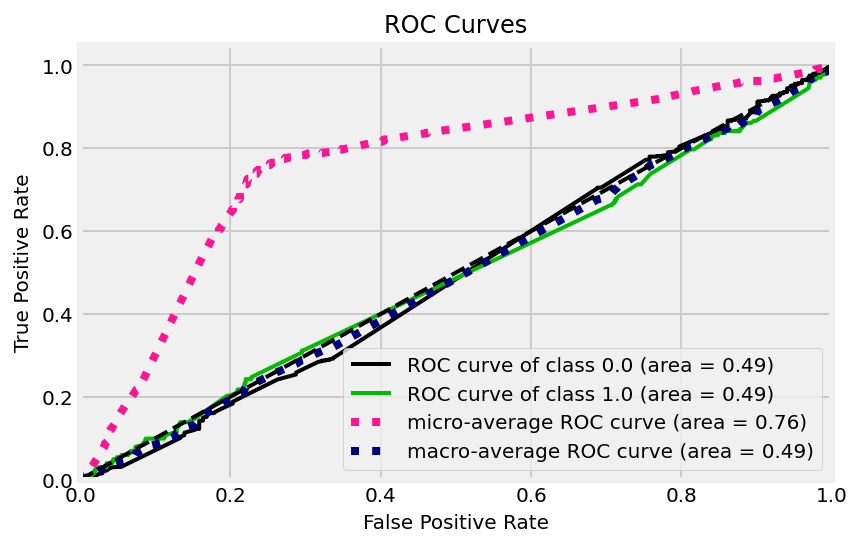

In [1126]:
# ROC Curve (test)
# Anything of note?

skplt.metrics.plot_roc(y_test, tvec_prob_test)
plt.show()

### Precision Recall

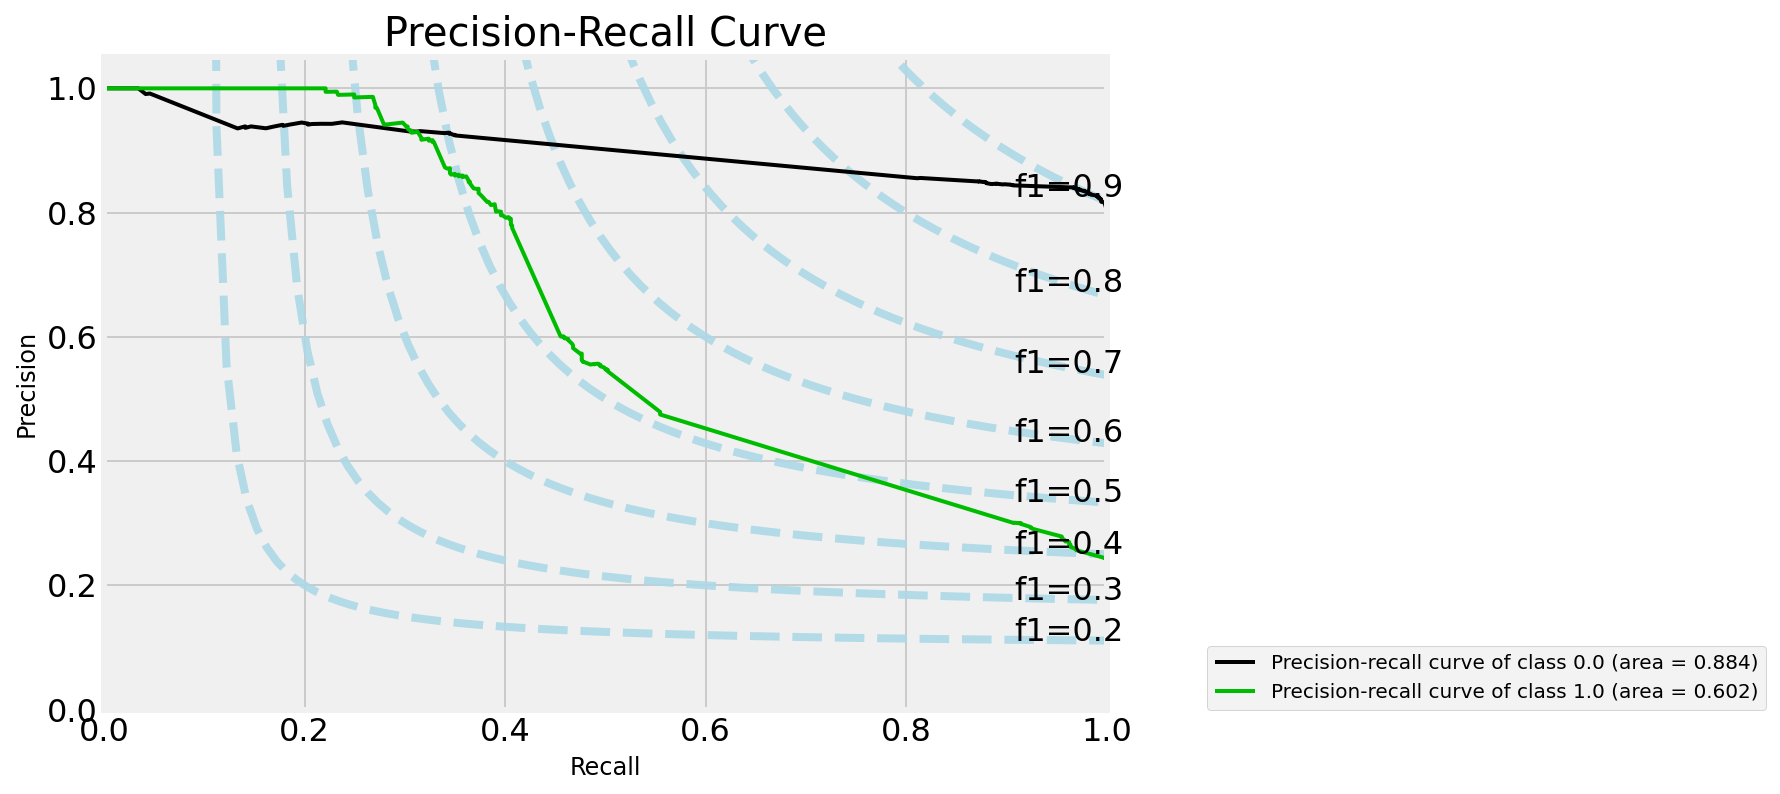

In [1127]:
# train

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_train, tvec_prob_train,
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

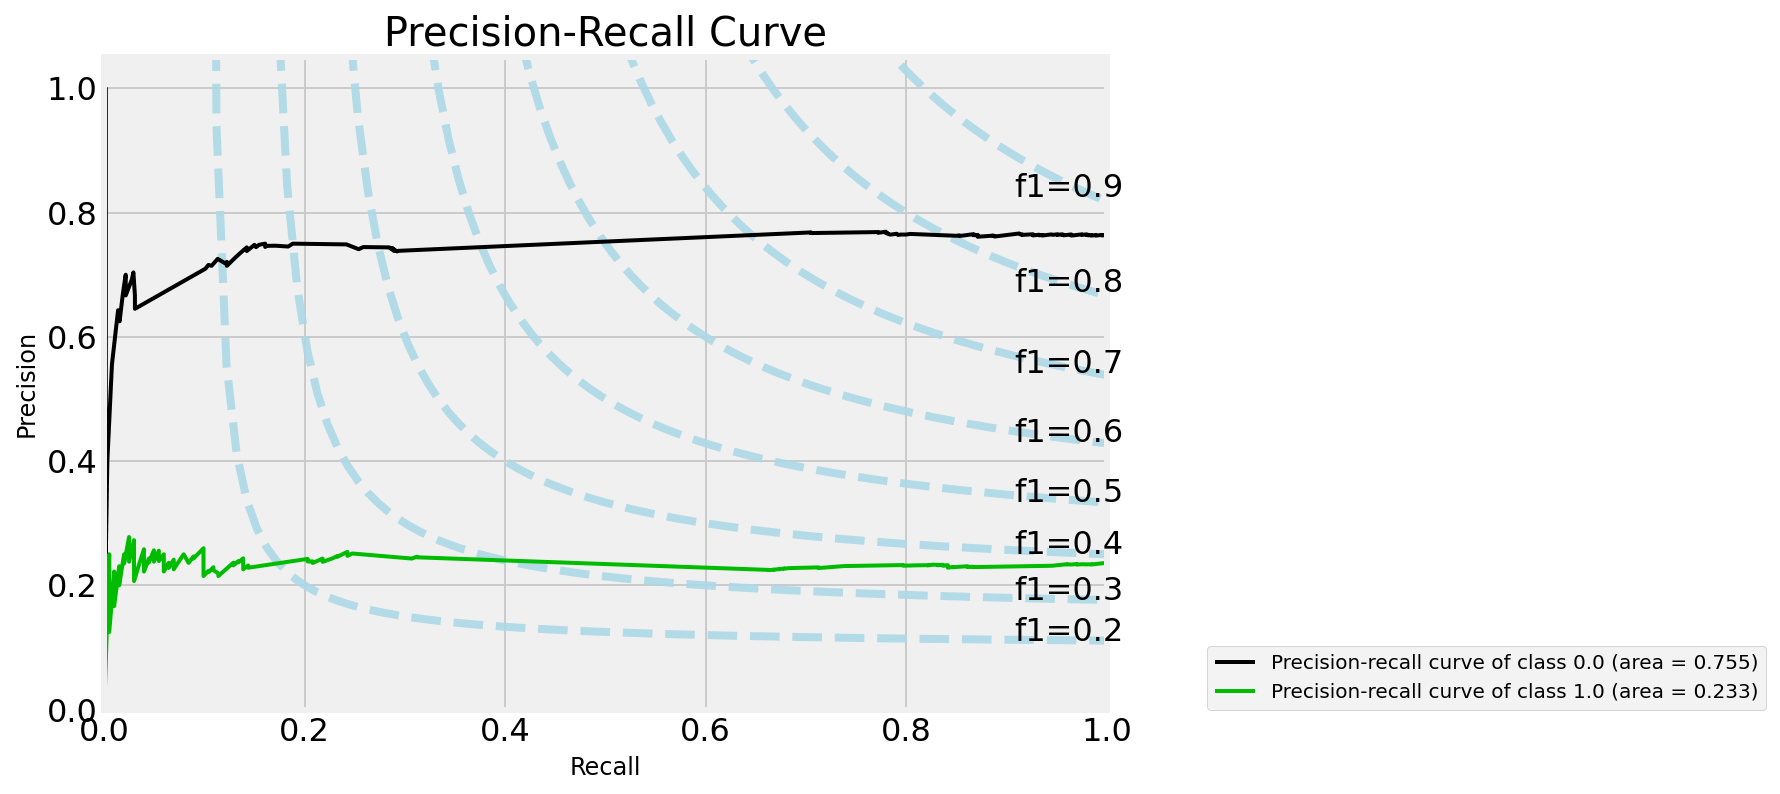

In [1128]:
# test

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, tvec_prob_test,
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()